# Attention Mechanism and Word Analogy using Pretrained Transformers
This script implements a self-attention mechanism and word analogy tasks using pretrained transformer models. 
It extracts query (Q), key (K), and value (V) weight matrices from the first attention layer of a specified transformer model 
and applies them to word embeddings to compute self-attention. 
The system performs word analogy operations to find relationships between words based on their embeddings 
and visualizes the attention weights using heatmaps to provide insights into the attention distribution across words in a sentence.

Realized by Vanni Leonardo

Requires: `numpy`, `matplotlib`, `seaborn`, `scipy`, `transformers`, and a GloVe embedding file (e.g., `glove.6B.100d.txt`).

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from transformers import AutoModel, AutoTokenizer

### Attention Weight Extraction from Pretrained Model

Define a class to load a specified transformer model and extract the Q, K, V weight matrices from its first self-attention layer. Then convert PyTorch parameters to numpy arrays.

In [5]:
class Attention:
    def __init__(self, model_name="bert-base-uncased"):
        self.model = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
                
        self.attention = self.model.encoder.layer[0].attention.self
        
    def get_attention_weights(self):
        W_Q = self.attention.query.weight.detach().numpy()
        W_K = self.attention.key.weight.detach().numpy()
        W_V = self.attention.value.weight.detach().numpy()
        
        return W_Q, W_K, W_V

### Word Embeddings and Analogy Functions

Functions to load pre-trained word embeddings from a file, calculate cosine similarity, and perform word analogy tasks to find relationships between words.

In [6]:
def load_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [7]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [8]:
def word_analogy(embeddings, word_a, word_b, word_c):
    vec_a = embeddings[word_a]
    vec_b = embeddings[word_b]
    vec_c = embeddings[word_c]
    analogy = vec_a - vec_b + vec_c

    max_sim = -np.inf
    best_word = None
    for word, vec in embeddings.items():
        if word in [word_a, word_b, word_c]:
            continue
        sim = cosine_similarity(analogy, vec)
        if sim > max_sim:
            max_sim = sim
            best_word = word
    return best_word

### Self-Attention Calculation

Functions to compute self-attention scores using the loaded embeddings and extracted weights with optional causal masking.

Args:

-embeddings (numpy.ndarray): Input embeddings matrix of shape (d, embedding_dim)

-W_Q (numpy.ndarray): Pretrained query weight matrix

-W_K (numpy.ndarray): Pretrained key weight matrix

-W_V (numpy.ndarray): Pretrained value weight matrix

-is_decoder (bool, optional): Whether to use causal masking for decoder. Defaults to False.

Returns:

-tuple: (output attention values, attention weights matrix)

In [9]:
def self_attention(embeddings, W_Q, W_K, W_V, is_decoder=False) -> tuple[np.ndarray, np.ndarray]:
    
    # Handle dimensionality matching
    d = embeddings.shape[0]
    d_k = W_Q.shape[0]  # Note: Shape is different with pretrained weights
    
    # Project embeddings to match pretrained weight dimensions if necessary
    if embeddings.shape[1] != d_k:
        projection_matrix = np.random.randn(embeddings.shape[1], d_k)
        embeddings = embeddings @ projection_matrix
    
    # Compute Q, K, V matrices
    Q = embeddings @ W_Q.T  
    K = embeddings @ W_K.T  
    V = embeddings @ W_V.T  
    
    # Compute scaled dot-product attention scores
    scores = (Q @ K.T) / np.sqrt(d_k)
    
    # Apply causal mask for decoder
    if is_decoder:
        mask = np.triu(np.ones((d, d)), k=1).astype(bool)
        scores[mask] = -np.inf
    
    # Apply softmax to get attention weights
    attention_weights = softmax(scores, axis=1)
    
    # Compute the output as weighted sum of values
    output = attention_weights @ V
    return output, attention_weights

### Visualization and Execution
Visualize the attention weights using heatmaps. Displays word analogy results and visualizes attention weights using matplotlib and seaborn.

Looking for GloVe file at: /Users/corradocalamita/Desktop/BAINSA/GitHubme/Word Embeddings and Transformers/glove.6B.100d.txt
Paris - France + Italy ≈ Rome


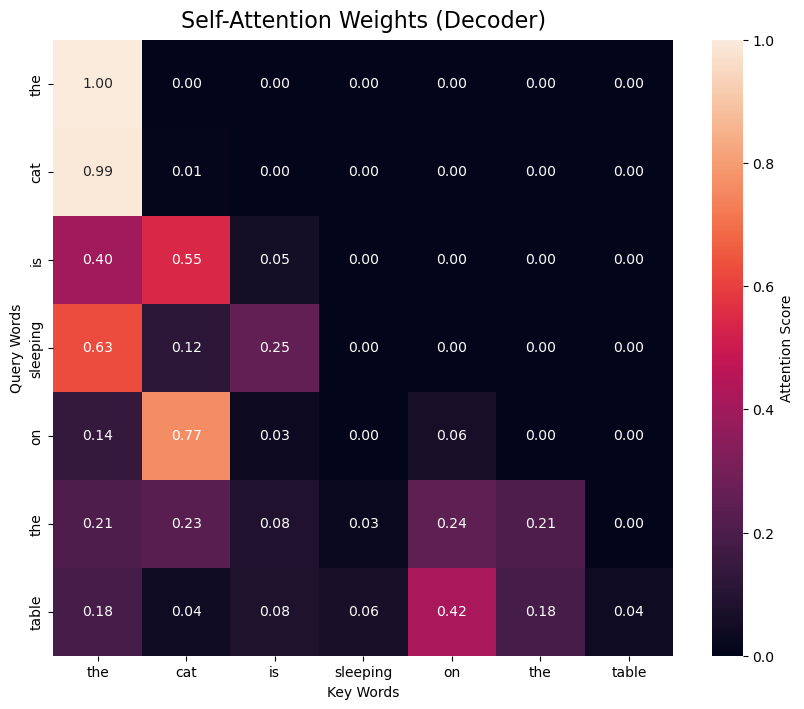

In [14]:
def visualize_attention(attention_weights, words=None, is_decoder=False):
    if words is None:
        words = [f'Word {i+1}' for i in range(attention_weights.shape[0])]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, fmt='.2f', xticklabels=words, yticklabels=words,
                cbar_kws={'label': 'Attention Score'})
    plt.text(0.5, 1.02, 'Self-Attention Weights' + (' (Decoder)' if is_decoder else ' (Encoder)'),
             horizontalalignment='center', fontsize=16, transform=plt.gca().transAxes)
    plt.ylabel('Query Words')
    plt.xlabel('Key Words')
    plt.show()

if __name__ == "__main__":
    # Initialize weight extractor
    weight_extractor = Attention()
    W_Q, W_K, W_V = weight_extractor.get_attention_weights()
    
    glove_filename = 'glove.6B.100d.txt'
    PATH = glove_filename
    
    
    # Load embeddings
    embeddings = load_embeddings(PATH)
    
    # Word analogy example
    result = word_analogy(embeddings, 'paris', 'france', 'italy')
    print(f"Paris - France + Italy ≈ {result.capitalize()}") # type: ignore
    
    # Self-attention example with pretrained weights
    sentence = ['the', 'cat', 'is', 'sleeping', 'on', 'the', 'table']
    E = np.array([embeddings[word] for word in sentence])
    # Normalize embeddings
    E = E / np.linalg.norm(E, axis=1, keepdims=True)

    IS_DECODER = True
    
    # Compute self-attention with pretrained weights
    new_embeddings, attention_matrix = self_attention(E, W_Q, W_K, W_V, is_decoder=IS_DECODER)
    
    visualize_attention(attention_matrix, sentence, is_decoder=IS_DECODER)